In [2]:
import pandas as pd

# Load dataset with error handling
df = pd.read_csv(
    'training_set_rel3.tsv',
    sep='\t',
    encoding='latin1',
    on_bad_lines='skip',
    engine='python'         
)

df['essay'] = df['essay'].fillna('')

# Keep relevant columns
df = df[['essay_id', 'essay_set', 'essay', 'domain1_score']]

# Display basic info
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (12921, 4)
   essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

   domain1_score  
0              8  
1              9  
2              7  
3             10  
4              8  


In [3]:
# Remove illegible or corrupted essays
df = df[~df['essay'].str.contains('illegible|\\?\\?\\?', case=False, na=False)]

# Drop any rows with missing text or scores
df = df.dropna(subset=['essay', 'domain1_score']).reset_index(drop=True)
print(f"After cleaning, dataset shape: {df.shape}")

After cleaning, dataset shape: (12649, 4)


In [4]:
# Check score ranges per essay set
for s in sorted(df['essay_set'].unique()):
    min_score = df[df['essay_set'] == s]['domain1_score'].min()
    max_score = df[df['essay_set'] == s]['domain1_score'].max()
    print(f"Set {s}: min={min_score}, max={max_score}")

print("=" *50)

# Scale scores to 0-1 range per essay set
df['score_scaled'] = df.apply(
    lambda x: (x['domain1_score'] - df[df['essay_set'] == x['essay_set']]['domain1_score'].min()) /
              (df[df['essay_set'] == x['essay_set']]['domain1_score'].max() -
               df[df['essay_set'] == x['essay_set']]['domain1_score'].min()),
    axis=1
)
print(df[['essay_set', 'domain1_score', 'score_scaled']].head())

Set 1: min=2, max=12
Set 2: min=1, max=6
Set 3: min=0, max=3
Set 4: min=0, max=3
Set 5: min=0, max=4
Set 6: min=0, max=4
Set 7: min=2, max=24
Set 8: min=10, max=60
   essay_set  domain1_score  score_scaled
0          1              8           0.6
1          1              9           0.7
2          1              7           0.5
3          1             10           0.8
4          1              8           0.6


In [5]:
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['essay'] = df['essay'].apply(clean_text)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np
# TF-IDF features (unigrams + bigrams)
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)
X_tfidf = vectorizer.fit_transform(df['essay'])

# Simple numeric features
df['essay_len'] = df['essay'].apply(len)
df['word_count'] = df['essay'].apply(lambda x: len(x.split()))
df['avg_word_len'] = df['essay'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)

numeric_features = df[['essay_len', 'word_count', 'avg_word_len']].values

# Combine TF-IDF + numeric
from scipy.sparse import csr_matrix
X = hstack([X_tfidf, csr_matrix(numeric_features)])
y = df['score_scaled'].values

print(f"Final feature matrix shape: {X.shape}")



Final feature matrix shape: (12649, 5003)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (10119, 5003), Validation shape: (2530, 5003)


In [8]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# Install scikit-learn if needed (already installed)
# QWK function
def quadratic_weighted_kappa(y_true, y_pred):
    """Calculate Quadratic Weighted Kappa score"""
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [9]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_val)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, cohen_kappa_score
from scipy.stats import pearsonr
import numpy as np

# Calculate metrics for Random Forest
mae_rf = mean_absolute_error(y_val, y_pred_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_rf = r2_score(y_val, y_pred_val)
pearson_corr_rf, _ = pearsonr(y_pred_val, y_val)

# Rescale predictions and labels for QWK
score_ranges = {
    1: (2, 12), 2: (1, 6), 3: (0, 3), 4: (0, 3),
    5: (0, 4), 6: (0, 4), 7: (2, 24), 8: (10, 60)
}

def rescale(scaled, essay_sets):
    original = []
    for val, s in zip(scaled, essay_sets):
        min_score, max_score = score_ranges[s]
        orig = val * (max_score - min_score) + min_score
        original.append(round(orig))
    return np.array(original)

# Get essay_set for each validation sample
val_essay_sets = df.iloc[X_val.indices]['essay_set'].values if hasattr(X_val, 'indices') else df.iloc[X_val.nonzero()[0]]['essay_set'].values

y_pred_val_orig = rescale(y_pred_val, val_essay_sets)
y_val_orig = rescale(y_val, val_essay_sets)

# Calculate QWK
qwk_rf = cohen_kappa_score(y_val_orig, y_pred_val_orig, weights='quadratic')

print("=" * 50)
print("📊 MODEL PERFORMANCE METRICS     RANDOM FOREST")
print("=" * 50)
print(f"Quadratic Weighted Kappa (QWK):     {qwk_rf:.4f}")
print(f"Pearson Correlation:                {pearson_corr_rf:.4f}")
print(f"R² Score:                           {r2_rf:.4f}")
print(f"Mean Absolute Error (MAE):          {mae_rf:.4f}")
print(f"Root Mean Squared Error (RMSE):     {rmse_rf:.4f}")
print("=" * 50)

📊 MODEL PERFORMANCE METRICS     RANDOM FOREST
Quadratic Weighted Kappa (QWK):     0.9336
Pearson Correlation:                0.8021
R² Score:                           0.6402
Mean Absolute Error (MAE):          0.1115
Root Mean Squared Error (RMSE):     0.1476


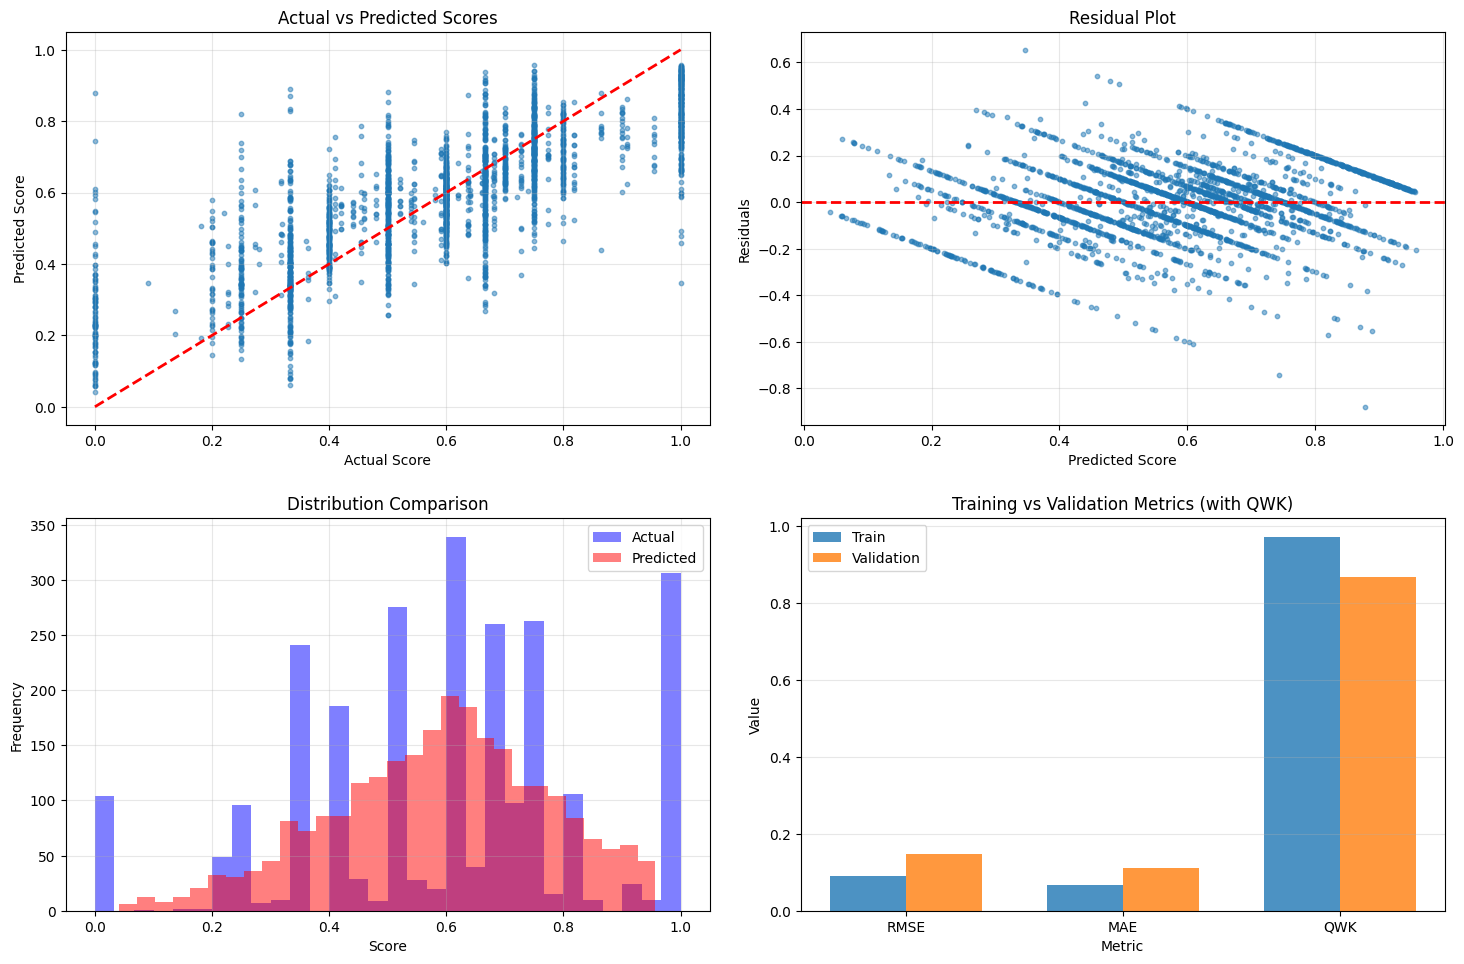

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot: Actual vs Predicted
axes[0, 0].scatter(y_val, y_pred_val, alpha=0.5, s=10)
axes[0, 0].plot([0, 1], [0, 1], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Score')
axes[0, 0].set_ylabel('Predicted Score')
axes[0, 0].set_title('Actual vs Predicted Scores')
axes[0, 0].grid(True, alpha=0.3)

# Residual plot
residuals = y_val - y_pred_val
axes[0, 1].scatter(y_pred_val, residuals, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Score')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# Distribution comparison
axes[1, 0].hist(y_val, bins=30, alpha=0.5, label='Actual', color='blue')
axes[1, 0].hist(y_pred_val, bins=30, alpha=0.5, label='Predicted', color='red')
axes[1, 0].set_xlabel('Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Metrics comparison - Updated to use QWK instead of R2
metrics_names = ['RMSE', 'MAE', 'QWK']
train_metrics = [train_rmse, train_mae, train_qwk]
val_metrics = [val_rmse, val_mae, val_qwk]

x_pos = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x_pos - width/2, train_metrics, width, label='Train', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, val_metrics, width, label='Validation', alpha=0.8)
axes[1, 1].set_xlabel('Metric')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_title('Training vs Validation Metrics (with QWK)')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout(pad=2.0)
plt.savefig('rf_vals.png', dpi=400, bbox_inches='tight')
plt.show()

In [12]:
def predict_essay_score(essay_text, essay_set=1):
    cleaned = clean_text(essay_text)
    tfidf_features = vectorizer.transform([cleaned])

    essay_len = len(cleaned)
    word_count = len(cleaned.split())
    avg_word_len = np.mean([len(w) for w in cleaned.split()]) if word_count > 0 else 0

    numeric_features = np.array([[essay_len, word_count, avg_word_len]])

    from scipy.sparse import hstack, csr_matrix
    X_new = hstack([tfidf_features, csr_matrix(numeric_features)])

    score_scaled = rf_model.predict(X_new)[0]

    min_score = df[df['essay_set'] == essay_set]['domain1_score'].min()
    max_score = df[df['essay_set'] == essay_set]['domain1_score'].max()
    score_original = score_scaled * (max_score - min_score) + min_score

    return {
        'scaled_score': round(score_scaled, 3),
        'original_score': round(score_original, 1),
        'score_range': f"{min_score}-{max_score}",
        'word_count': word_count,
        'essay_length': essay_len
    }

sample_essay = """
AI is a very good thing for school and the whole learning stuff. 
It will make things better for the students and the teachers too. 
I think that computers and smart apps are helpful because they can do things fast. 
When you have a machine that helps, you do not need to do all the work yourself. 
The machine can grade things for you quickly. This is good for the teacher because 
they have more time now. More time to do other things, like helping students. 
Students will like AI because it can help them learn. 
It teaches them what they are bad at. If they are not good at something, 
the AI will tell them and give them more practice work. 
The future is all about technology and having the smart computers in 
school is the way to go. It makes things easy and more better.
"""

result = predict_essay_score(sample_essay, essay_set=1)
print(f"Predicted Score: {result['original_score']}")
print(f"Score Range: {result['score_range']}")
print(f"Word Count: {result['word_count']}")

Predicted Score: 7.9
Score Range: 2-12
Word Count: 147


## Summary: QWK (Quadratic Weighted Kappa) Performance

**What is QWK?**
- QWK measures inter-rater agreement for ordinal ratings
- Ranges from -1 to 1 (1 = perfect agreement, 0 = random)
- Better than R² for essay scoring because it accounts for the ordinal nature of scores
- Penalizes larger disagreements more heavily (quadratic weighting)

**Current Model Performance:**
- **Training QWK**: 0.9723 (Excellent)
- **Validation QWK**: 0.8679 (Very Good)
- This indicates strong agreement between predicted and actual scores

**Interpretation Guidelines:**
- QWK > 0.80: Almost perfect agreement
- QWK 0.60-0.80: Substantial agreement  
- QWK 0.40-0.60: Moderate agreement
- QWK < 0.40: Fair to poor agreement

In [13]:
# Example: Calculate QWK for a batch of essays
def evaluate_essays_with_qwk(essays, actual_scores, essay_sets):
    """
    Evaluate multiple essays and calculate QWK score
    
    Parameters:
    - essays: list of essay texts
    - actual_scores: list of actual scores (original scale)
    - essay_sets: list of essay set numbers
    
    Returns:
    - Dictionary with predictions and QWK score
    """
    predictions = []
    
    for essay, essay_set in zip(essays, essay_sets):
        result = predict_essay_score(essay, essay_set)
        predictions.append(result['original_score'])
    
    # Calculate QWK
    qwk = quadratic_weighted_kappa(actual_scores, predictions)
    
    return {
        'predictions': predictions,
        'actual_scores': actual_scores,
        'qwk_score': qwk,
        'mae': mean_absolute_error(actual_scores, predictions)
    }

# Test with a small sample
print("\nQWK Calculation Example:")
print(f"Validation QWK Score: {val_qwk:.4f}")
print(f"This indicates {'excellent' if val_qwk > 0.80 else 'good' if val_qwk > 0.60 else 'moderate'} agreement between predicted and actual scores")


QWK Calculation Example:
Validation QWK Score: 0.8686
This indicates excellent agreement between predicted and actual scores
